In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import h5py
import fklab.ratemap as rm
import fklab.ratemap.utilities
import fklab.behavior.simulation
import fklab.spikes.simulation
import fklab.plot.plots
import fklab.geometry.shapes as shapes
import numpy as np

%matplotlib inline

from data_analysis import loading


In [188]:
loading.load_project('/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0')
loading.load_cluster()
ls_data = loading.cluster_data
# loading.load_position('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
loading.load_kilosort()
loading.load_event('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/Events.nev',)


In [180]:
Fs = 3000
time_shift = -6.439110058088235
position_time = np.array(loading.position_time)
corrected_time = position_time + time_shift

In [189]:
with h5py.File("/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/epochs/training/position.hdf5") as f:
   f["data1"] = position

/home/kasia/miniconda3/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


NameError: name 'position' is not defined

In [4]:
project_root = '/media/kasia/K/Neuropixeldata/Th1_ca3_9/catgt_29112019_g0'

clusters = np.load(project_root + "spike_clusters.npy")
# print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")

y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")

In [5]:
#loading clusters 
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={7:lambda fr: fr.replace(b' spk/s', b'')})
#print(data[data['KSLabel'] == 'good'])
# data_good = data[data['KSLabel']== 'good']
data_good = data[data['group'] == 'good']

In [6]:
depth = data_good['depth']
n_spk = data_good['n_spikes']
id_s = data_good['id']
channel= data_good['channel']

In [7]:
import pandas as pd
channel_cluster = []
channel_label = []

for cluster_index, cluster_id in enumerate(id_s):
    channel_cluster.append(str(cluster_id)) 
    channel_label.append(str(channel[cluster_index]))

    
cluster_channel = pd.DataFrame({'cluster':channel_cluster,'channel':channel_label})    

# print(cluster_channel)
cluster_channel.to_csv('Cluster_channel_LS_K_5_140320.tsv', sep = '\t')

In [8]:
epoch = loading.position_yaml['source']['epoch']
epoch
open_field_epoch = [2331, 3515]
Y_maze_epoch = [3533, 5230]

from fklab.geometry.shapes import rectangle
open_field_data = loading.environment_yaml['open_field']['shapes']['open_field']['shape']
open_field = rectangle(**open_field_data)

In [9]:
position_of = loading.position[np.logical_and(corrected_time > open_field_epoch[0],
                                      corrected_time < open_field_epoch[1]), :]
position_of_cm = position_of * 0.27

In [10]:
cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
ks_spike_times = loading.ks_spike_times[:, 0]
spike_time_rangeof = np.array(open_field_epoch) - loading.evt_start_time[1] + time_shift
spike_t = {}
for cl in cluster_channel['cluster']:
    spike_xof = ks_spike_times[loading.get_spike_seq(spike_time_rangeof, cluster_list=[cl] )] + loading.evt_start_time[1]

    spike_t[cl]=spike_xof
    

t_of = corrected_time[np.logical_and(corrected_time > open_field_epoch[0], corrected_time < open_field_epoch[1])]

In [11]:
from fklab.geometry.shapes import rectangle
open_field_data = loading.environment_yaml['open_field']['shapes']['open_field']['shape']
open_field = rectangle(**open_field_data)

boundary_half_size = 33
boundary_points = open_field.samplepath(oversampling=25, openpath=True)



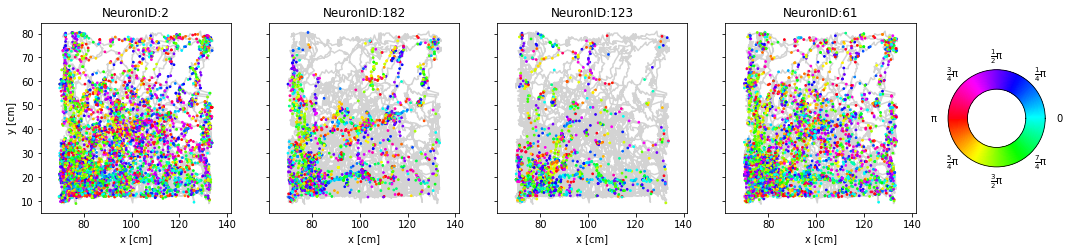

In [173]:
x=position_of_cm[:,0]
y=position_of_cm[:,1]

# m = ~np.logical_or(np.isnan(x), np.isnan(y))
# x= x[m]
# y=y[m]
# t_of = t_of[m]

xy = np.column_stack([position_of_cm])
dt=1/25
velocity = np.gradient(x,dt)+np.gradient(y,dt)*1.0j
speed = np.abs(velocity)

# compute heading direction
phi = np.angle(velocity)

spike_t1 = {}
spike_t1 = (spike_t[2],spike_t[182], spike_t[123], spike_t[61])


# compute location and heading at time of spikes
simxy = [fklab.ratemap.compute_variable_at_times(k, xy, var_t=t_of)
         for k in spike_t1]
# simxy = {key: rm.compute_variable_at_times(k,xy, var_t=t_of) for key, k in spike_t1.items()}

simphi = [fklab.ratemap.compute_variable_at_times(k, phi, var_t=t_of)
          for k in spike_t1]
# simxy = {key: rm.compute_variable_at_times(k, phi, var_t=t_of) for key, k in spike_t.items()}

celltypes = ['NeuronID:2','NeuronID:182','NeuronID:123', 'NeuronID:61']

fig, axes = plt.subplots(1, len(celltypes), sharex=False, sharey=True,
                         figsize=(18,3.5),
                         gridspec_kw={'right':0.8})

colscale = matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)

for celltype, _xy, _phi, ax in zip(celltypes, simxy, simphi, axes.ravel()):

    ax.plot(x, y, color='lightgray', zorder=0)

    h = ax.scatter(_xy[:,0], _xy[:,1],
                   c=_phi, s=3, cmap='hsv',
                   norm=colscale)

    ax.axis('equal') # does not work when both sharex and sharey are True :(
    ax.set(xlabel='x [cm]', title=celltype)

axes[0].set(ylabel='y [cm]')

cax = fig.add_axes([0.825, 0, 0.075, 1], polar=True)
fklab.plot.plots.polar_colorbar(cax, rotation=-np.pi, annulus=0.75,
                                show_theta_axis=True, style='math')

plt.savefig("/media/kasia/K/Neuropixeldata/Data_Analysis/notebooks/Plots/LS_K_5_140320_OF/Heading_colormapOF_2_182_123_61.png")

In [110]:
bnd_dist, bnd_angle = fklab.ratemap.utilities.egocentric_coordinates(
    xy, phi, boundary_points, maxdistance=boundary_half_size
)

/media/kasia/K/Neuropixeldata/Data_Analysis/fklab-python-internal/fklab/ratemap/utilities.py:176: RuntimeWarning: invalid value encountered in greater
  b = target_distance > maxdistance


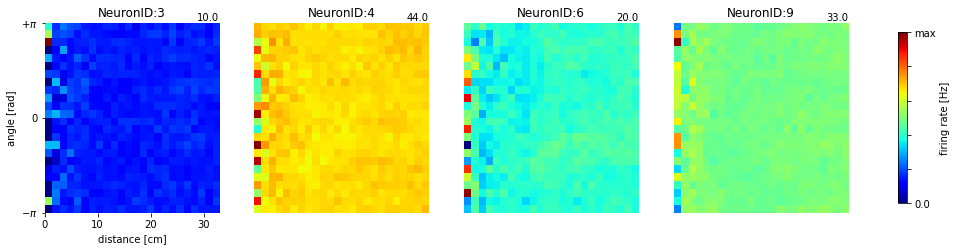

In [111]:
bins = [np.linspace(0,boundary_half_size,25), np.linspace(-np.pi,np.pi,25)]

ratemap, spikecount, occ, grid = rm.hist.general_tuning(
    *spike_t1, stimdata=np.stack([bnd_dist, bnd_angle], axis=-1),
    t=t_of, dt=dt, bins=bins)

fig, axes = fklab.plot.plots.plot_2d_maps(
    ratemap, coordinates=bins,
    xlabel='distance [cm]',
    ylabel='angle [rad]',
    colorlabel='firing rate [Hz]',
    cmap='jet',
    cbar=True,
    cbar_kw={'shrink':0.9},
    cmin=0, cmax='auto',
    roundto=1,
    grid=(None,4),
    figsize=(18,3.5)
)

axes[0,0].set_yticks([-np.pi,0,np.pi])
axes[0,0].set_yticklabels([r'$-\pi$', '0', r'$+\pi$']);

for label, ax in zip(celltypes,axes.ravel()):
    ax.set(title=label)
    ax.set_frame_on(False)
    
plt.savefig('/media/kasia/K/Neuropixeldata/Data_Analysis/notebooks/Plots/LS_K_5_140320_OF/firingratemap_3_4_6_9.png')

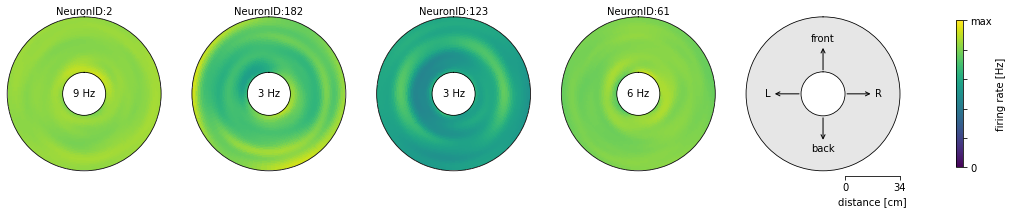

In [174]:
ratemap, spikecount, occ, grid = rm.kde.vector_tuning(
    *spike_t1, t=t_of, dt=dt,
    vectors=np.stack([bnd_dist, bnd_angle], axis=-1),
    kappa=8, bandwidth=2,
    grid = np.linspace(0,boundary_half_size, 35),
    offset=-np.pi,
    compression=1.)

polar_props = {
    'style': 'egocentric',
    'style_kw': {'labels': {90: 'L', 270: 'R'}},
    'radial_min': 0,
    'radial_max': boundary_half_size,
    'radial_ticks':[0,34],
    'annulus': 0.2,
    'radial_label': 'distance [cm]'
}

fig, axes = fklab.plot.plots.setup_polar_axes_grid(
    len(celltypes), grid=(1,None), figsize=(20,3),
    show_reference=True, reference_kw={'facecolor':[0.9,0.9,0.9]},
    axes_props=polar_props);

roundto = 1

for celltype, data, ax in zip(celltypes, ratemap, axes.ravel()):
    vmax = np.ceil(np.nanmax(data)/roundto)*roundto
    
    fklab.plot.plots.plot_polar_map(
        data, theta=grid[1], rho=grid[0], ax=ax, vmax=vmax, vmin = 0, cmap='viridis')

    fklab.plot.plots.axes_annotation(ax, "{:.0f} Hz".format(vmax),
                                     hloc='center',vloc='center')

    fklab.plot.plots.axes_annotation(ax, celltype,
                                     hloc='center',vloc='top out')
    

fklab.plot.plots.fixed_colorbar(vmax='max', ax=axes, label='firing rate [Hz]',
                shrink=0.9, orientation='vertical', ndivisions=5, cmap="viridis")


plt.savefig('/media/kasia/K/Neuropixeldata/Data_Analysis/notebooks/Plots/LS_K_5_140320_OF/egocentricBC_2_182_123_61.png')

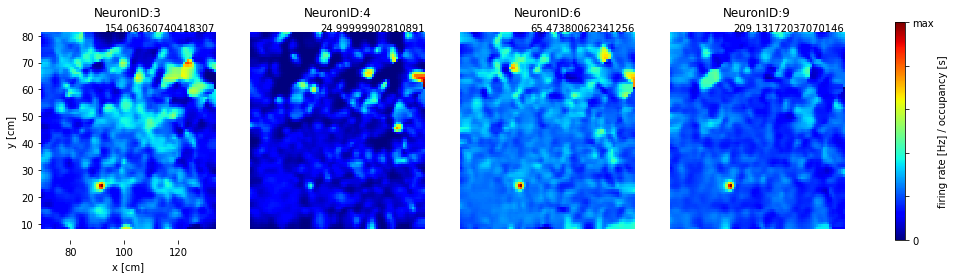

In [147]:
from os import path
from fklab.signals.smooth import create_smoother
import fklab.ratemap as rm
from fklab.plot.plots import plot_2d_maps


stackxy = np.column_stack([position_of_cm])
eventxy = [rm.compute_variable_at_times(z, variable=stackxy, var_t=t_of)
           for z in spike_t1]

rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
    *eventxy,
    stimdata = stackxy,
    stimduration=1/25,
    smooth = 1,
    bins = [np.linspace(69,134,80), np.linspace(8,81,80)])



fig, axes = plot_2d_maps(
    [*rmap_hist],
    coordinates=binedges,
    cmap='jet',
    xlabel="x [cm]",
    ylabel="y [cm]",
    colorlabel="firing rate [Hz] / occupancy [s]",
    cbar=True,
    grid=(None,4),
    figsize=(18,4),
    cmin=0, cmax= 'auto',
#     roundto=.5
)

axes[0,0].set(title='NeuronID:3')
axes[0,1].set(title='NeuronID:4')
axes[0,2].set(title='NeuronID:6')
axes[0,3].set(title='NeuronID:9');

for ax in axes.ravel():
    ax.set_frame_on(False)
    ax.axis('equal')

plt.savefig("/media/kasia/K/Neuropixeldata/Data_Analysis/notebooks/Plots/LS_K_5_140320_OF/Rate_map_OF_3_4_6_9.png")

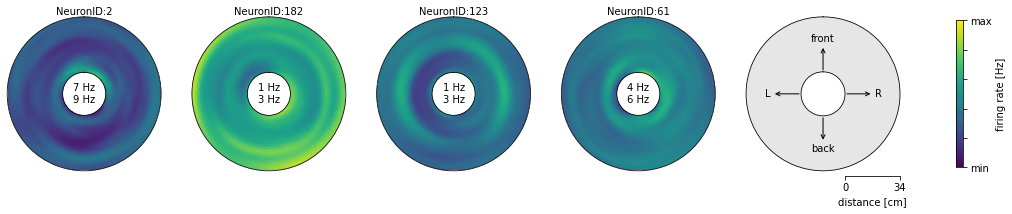

In [175]:
polar_props = {
    'style': 'egocentric',
    'style_kw': {'labels': {90: 'L', 270: 'R'}},
    'radial_min': 0,
    'radial_max': boundary_half_size,
    'radial_ticks':[0,34],
    'annulus': 0.2,
    'radial_label': 'distance [cm]'
}

fig, axes = fklab.plot.plots.setup_polar_axes_grid(
    len(celltypes), grid=(1,None), figsize=(20,3),
    show_reference=True, reference_kw={'facecolor':[0.9,0.9,0.9]},
    axes_props=polar_props);

roundto = 1

for celltype, data, ax in zip(celltypes, ratemap, axes.ravel()):
    vmax = np.ceil(np.nanmax(data)/roundto)*roundto
    vmin = np.floor(np.nanmin(data)/roundto)*roundto
    fklab.plot.plots.plot_polar_map(
        data, theta=grid[1], rho=grid[0], ax=ax, vmax=vmax, vmin=vmin, cmap='viridis')
    fklab.plot.plots.axes_annotation(ax, "{:.0f} Hz\n{:.0f} Hz".format(vmin,vmax),
                                     hloc='center',vloc='center')
    fklab.plot.plots.axes_annotation(ax, celltype,
                                     hloc='center',vloc='top out')
fklab.plot.plots.fixed_colorbar(vmax='max', vmin='min', ax=axes, label='firing rate [Hz]',
                shrink=0.9, orientation='vertical', ndivisions=5, cmap="viridis")

